## Overview

*Star Type Classification / NASA*

For this dataset, we'll be classifying the type of star given our dataset.
In particular, if the star is appropriately labeled as a Red Drawf, Hyper Giant, etc.

As there are multiple possible outputs, we should be keen to note that this is a multiple classification problem.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import altair as alt

from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from six import StringIO  
import pydotplus
from sklearn.metrics import accuracy_score

%matplotlib inline

C:\Users\rngaw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
stars = pd.read_csv('Stars.csv')

In [3]:
stars.sample(n = 10, random_state = 42)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
24,16500,0.01,0.01,11.89,Blue White,B,2
6,2637,0.00,0.13,17.22,Red,M,0
93,4980,0.36,1.13,4.78,Yellowish,K,3
109,33421,352000.00,67.00,-5.79,Blue,O,4
104,11096,112000.00,12.00,-5.91,Blue,O,4
172,4287,630000.00,1315.00,-9.20,Orange,K,5
233,27739,849420.00,1252.00,-7.59,Blue-white,B,5
86,12010,0.00,0.01,12.13,Blue White,B,2
9,2700,0.00,0.13,16.05,Red,M,0
143,14520,0.00,0.01,11.92,Blue White,B,2


In [4]:
print(stars.info(), '\n', stars.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB
None 
 Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64


In [5]:
stars.describe()

,Temperature,L,R,A_M,Type
count,240.00,240.00,240.00,240.00,240.00
mean,10497.46,107188.36,237.16,4.38,2.50
std,9552.43,179432.24,517.16,10.53,1.71
min,1939.00,0.00,0.01,-11.92,0.00
25%,3344.25,0.00,0.10,-6.23,1.00
50%,5776.00,0.07,0.76,8.31,2.50
75%,15055.50,198050.00,42.75,13.70,4.00
max,40000.00,849420.00,1948.50,20.06,5.00


In [6]:
stars.Type.value_counts()

5    40
4    40
3    40
2    40
1    40
0    40
Name: Type, dtype: int64

Just at face-value, we can see that our target labels are normally distributed.

## Data Cleaning

In [7]:
# We'll get all the unique values and do a sort to see like values easier
color_list = []

for n in stars['Color'].unique():
    color_list.append(n)

color_list.sort()

color_list

['Blue',
 'Blue White',
 'Blue white',
 'Blue-White',
 'Blue-white',
 'Orange',
 'Orange-Red',
 'Pale yellow orange',
 'Red',
 'White',
 'White-Yellow',
 'Whitish',
 'Yellowish',
 'Yellowish White',
 'white',
 'yellow-white',
 'yellowish']

We can see some values that are similar but have some character dissimilarities, such as 'Blue White'

Let's see how the data is distributed and go from there.

In [8]:
alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Color:N', sort = '-x')
    )

alt.Chart(...)

We can infer that the color observations were probably made by direct observations.

Data of the Metalicity of the stars, would allow for use of something like a B-V Color Index. 

We'll instead relabel the color labels to something a bit more appropriate for out test.

In [9]:
color_map = {'Orange-Red' : 'Orange-Red', 
             'Pale yellow orange' : 'Yellow-Orange',
             'Blue-white' : 'Blue-White', 
             'Blue White' : 'Blue-White',
             'Blue white' : 'Blue-White',
             'Blue-White' : 'Blue-White', 
             'yellow-white' : 'Yellow-White',
             'Yellowish White' : 'Yellow-White',
             'White-Yellow' : 'Yellow-White',
             'yellowish' : 'Yellow',
             'Yellowish' : 'Yellow',   
             'White' : 'White',
             'white' : 'White',
             'Whitish' : 'White',
             'Orange' : 'Orange', 
             'Red' : 'Red', 
             'Blue' : 'Blue'
            }   

stars.Color = stars.Color.map(color_map).astype('category')
stars.Spectral_Class = stars.Spectral_Class.astype('category')

In [10]:
alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Color', sort = '-x')
    )

alt.Chart(...)

We'll also label encode the spectral class and color columns as they are ordinal data

In [11]:
le = LabelEncoder()

In [12]:
# Map original labels for future reference
le.fit(stars['Spectral_Class'])
le_name_mapping_spectral_class = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(stars['Color'])
le_name_mapping_color = dict(zip(le.classes_, le.transform(le.classes_)))
print('Spectral Classes Mapping: ', le_name_mapping_spectral_class, 
      '\n\nColor Mapping: ', le_name_mapping_color)

Spectral Classes Mapping:  {'A': 0, 'B': 1, 'F': 2, 'G': 3, 'K': 4, 'M': 5, 'O': 6} 

Color Mapping:  {'Blue': 0, 'Blue-White': 1, 'Orange': 2, 'Orange-Red': 3, 'Red': 4, 'White': 5, 'Yellow': 6, 'Yellow-Orange': 7, 'Yellow-White': 8}


In [13]:
sc_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Spectral_Class', sort = '-x')
).properties(
    height = 100,
    width = 100
)

r_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('R:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

l_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('L:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

temperature_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Temperature:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

sc_chart | r_chart | l_chart | temperature_chart

alt.HConcatChart(...)

In [14]:
# Apply transformations
stars['Color'] = le.fit_transform(stars['Color'])
stars['Spectral_Class'] = le.fit_transform(stars['Spectral_Class'])

In [15]:
sc_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Spectral_Class', sort = '-x')
).properties(
    height = 100,
    width = 100
)

r_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('R:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

l_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('L:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

temperature_chart = alt.Chart(stars).mark_bar().encode(
    x = 'count()',
    y = alt.Y('Temperature:Q', bin = True)
).properties(
    height = 100,
    width = 100
)

sc_chart | r_chart | l_chart | temperature_chart

alt.HConcatChart(...)

The features for radii and luminosity seem to have a heavily skewed distribution.

We'll want to provide a log transformation to both of these.
Our main reason is because for star categorization, radii and luminosity seem to be based on
relative changes rather than absolute, in regards to classification.

Before applying the transformation, let's see what the data looks like beforehand.

In [16]:
alt.Chart(stars).mark_point().encode(
    alt.X(alt.repeat('column'), type = 'quantitative'),
    alt.Y(alt.repeat('row'), type = 'quantitative'),
    color = 'Type:N'
).properties(
    width = 200,
    height = 200
).repeat(
    row = ['L', 'R'],
    column = ['Temperature', 'A_M', 'Spectral_Class', 'Color']
)

alt.RepeatChart(...)

In [17]:
stars['L'] = np.log(stars.L).astype(float)
stars['R'] = np.log(stars.R).astype(float)

In [18]:
alt.Chart(stars).mark_point().encode(
    alt.X(alt.repeat('column'), type = 'quantitative'),
    alt.Y(alt.repeat('row'), type = 'quantitative'),
    color = 'Type:N'
).properties(
    width = 200,
    height = 200
).repeat(
    row = ['L', 'R'],
    column = ['Temperature', 'A_M', 'Spectral_Class', 'Color']
)

alt.RepeatChart(...)

## Analysis Part I

We'll take an overall peak of the data and take a deeper dive if we need to.

In [19]:
alt.Chart(stars).mark_point().encode(
    alt.X(alt.repeat('column'), type = 'quantitative'),
    alt.Y(alt.repeat('row'), type = 'quantitative'),
    color = 'Type:N'
).properties(
    width = 200,
    height = 200
).repeat(
    row = ['Temperature', 'L', 'R', 'A_M', 'Spectral_Class', 'Color'],
    column = ['Temperature', 'L', 'R', 'A_M', 'Spectral_Class', 'Color']
)

alt.RepeatChart(...)

Here are a few observations from our plots

    1. Radius, luminosity and absolute magnitude seem to have a role in the type of star
    2. Radii and absolute magnitude seems to seperate the types better
    3. It seems that radii plays an integral role in determining the type of star
    4. Main sequence stars seem to have the widest spread

To further go off of points 2 and 3, it seems to make sense, especially if we refer to the Hertzsprung-Russell Diagram


In particular, the type of star may have some relationship to the equation:

    L = Area x Flux = 4πR^2σSBT^4
   
Let's do a little bit more diving before creating a model

In [20]:
heatmap = alt.Chart(stars).mark_rect().encode(
    alt.X('A_M:Q', bin = True),
    alt.Y('Temperature:Q', bin = True),
    alt.Color('count()', scale = alt.Scale(scheme = 'greenblue'))
)

points = alt.Chart(stars).mark_circle(
    color = 'black',
    size = 5,
).encode(
    x = 'A_M:Q',
    y = 'Temperature:Q',
)

heatmap + points

alt.LayerChart(...)

In [21]:
chart = alt.Chart(stars).mark_circle().encode(
    x = 'L:Q',
    y = 'R:Q',
).properties(
    height = 300,
    width = 300
)

chart + chart.transform_regression('L', 'R', method = 'poly').mark_line()

alt.LayerChart(...)

## Modeling

In [22]:
X = stars.drop(['Type'], axis = 1)
y = stars['Type']

features = X.columns
target = 'Type'

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

Instead of testing each and every classifier, we'll use LazyPredict.
If a model seems promising, we might do a deeper dive into other related models that are not covered
via LazyPredict.

In [29]:
models = LazyClassifier(verbose = 0, ignore_warnings = True, custom_metric = None, predictions = True)
model, predictions = models.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 40.58it/s]


In [30]:
model.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,1.00,1.00,None,1.00,0.07
XGBClassifier,1.00,1.00,None,1.00,0.05
DecisionTreeClassifier,1.00,1.00,None,1.00,0.01
RandomForestClassifier,1.00,1.00,None,1.00,0.12
ExtraTreesClassifier,1.00,1.00,None,1.00,0.09
BaggingClassifier,1.00,1.00,None,1.00,0.02
GaussianNB,0.98,0.98,None,0.98,0.01
LinearDiscriminantAnalysis,0.96,0.96,None,0.96,0.01
SVC,0.94,0.94,None,0.94,0.01


Our top 10 models have a near 100% accuracy rating, but this could be due to the fact that the dataset is small, or some other factors. 

For now, we'll go with Decision Tree Classification for the following reasons:

    1. Short runtime
    2. Trees are less susceptible to label encoded data

In [31]:
dt = DecisionTreeClassifier(random_state = 42)

In [32]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [33]:
importance = dt.feature_importances_

In [34]:
importance = pd.DataFrame(importance).T
importance.columns = features
importance = importance.T.reset_index()
importance.columns = ['Features', 'Importance']

In [35]:
alt.Chart(importance).mark_bar().encode(
    x = 'Features',
    y = 'Importance',
    ).properties(width = 200, height = 200)

alt.Chart(...)

When we look back at the graphs above, radii and absolute magnitude have seemed to play a role in classification.

Surprisingly, luminosity did not have more weight in classification.

In [36]:
text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_2 <= -3.53
|   |--- class: 2
|--- feature_2 >  -3.53
|   |--- feature_3 <= 8.31
|   |   |--- feature_3 <= -4.90
|   |   |   |--- feature_2 <= 5.57
|   |   |   |   |--- class: 4
|   |   |   |--- feature_2 >  5.57
|   |   |   |   |--- class: 5
|   |   |--- feature_3 >  -4.90
|   |   |   |--- class: 3
|   |--- feature_3 >  8.31
|   |   |--- feature_3 <= 15.51
|   |   |   |--- class: 1
|   |   |--- feature_3 >  15.51
|   |   |   |--- class: 0



In [37]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

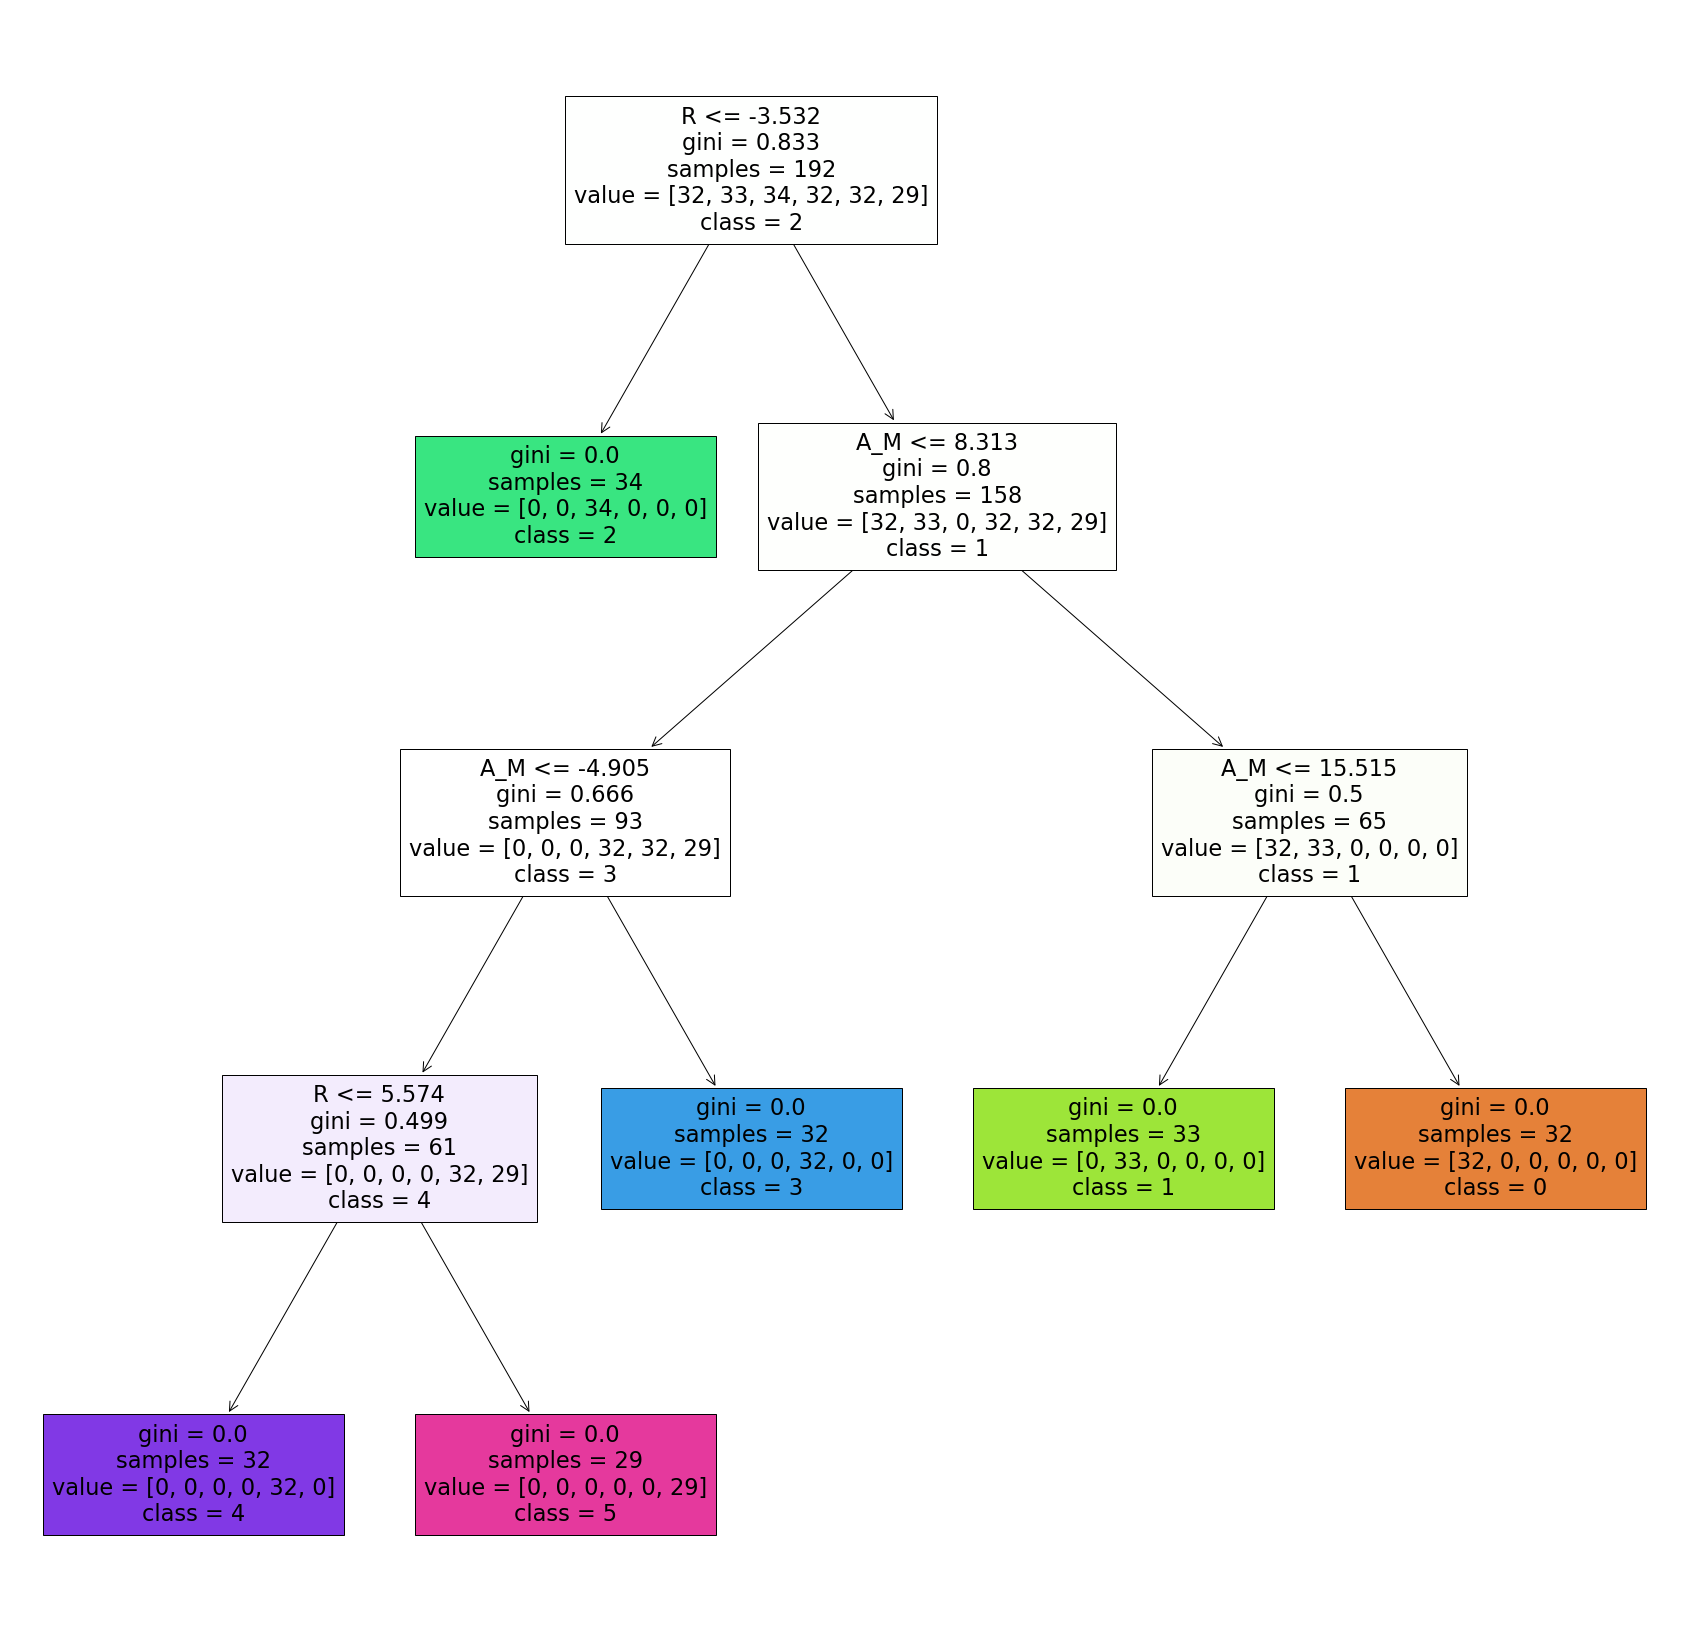

In [38]:
plt.figure(figsize = (30, 30))
tree.plot_tree(dt, feature_names = features,  
                     class_names = ['0', '1', '2', '3', '4', '5'],  filled = True)
plt.savefig('Star_Type.png')

In [39]:
yhat_test = dt.predict(X_test)
acc = accuracy_score(y_test, yhat_test)
print('Accuracy Score: ', acc)

Accuracy Score:  1.0


## Conclusion

For now, it seems we can draw a conclusion that absolute magnitude and radii are integral to classifying the type of star. With such a small dataset, it seems like the accuracy score is appropriate enough, especially at 100%. 

While we can certainly do feature selection and "improve" upon the decision tree, it does not seem necessary at this time.

#### Other Thoughts
I think it would have been nice to see the colors in a B-V Color Index. It would be interesting to see how metalicity would play a more integral role in the classification of stars.